# Backtesting Mercury Challenge Time Series Baserate Models

This notebook illustrates a backtest of the Mercury Challenge Baserate models for the Case Count events.  See [Developing Mercury Time Series Models](./Fit%20CU%20Time%20Series%20Models.ipynb) for model development details.

In [2]:
%matplotlib inline

In [3]:
import os
import json
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import (plot_acf, plot_pacf)
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import datetime
from dateutil.parser import parse
import sys
sys.path.append(("../.."))
from Baserate.main.timeseries import (
    evaluate_arima_model, 
    evaluate_models, 
    mean_qs_error, 
    TsDefaults,
    one_step_ahead_forecast,
    hist_avg_predict,
    future_dates
)
from ExpressScore.main.express_score import CaseCountScorer
import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("fivethirtyeight");

/anaconda3/envs/mercury/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
EVT_ABBR = "Disease"
MC_HOME = os.path.abspath("../../..")
DOC_PATH = os.path.join(MC_HOME, "doc")
EVT_DOC_PATH = os.path.join(DOC_PATH, "scoring", EVT_ABBR)
DATA_PATH = os.path.join(MC_HOME, "data")
GSR_PATH = os.path.join(DATA_PATH, "gsr")
DISEASE_GSR_PATH = os.path.join(GSR_PATH, "disease_gsr")
WARN_PATH = os.path.join(DATA_PATH, "baserate_warnings")
DIS_WARN_PATH = os.path.join(WARN_PATH, "baserate_disease_warnings")
RESOURCE_PATH = os.path.join(MC_HOME, "src", "Baserate", "resources")
TRAIN_START_DATE = "2015-05-01"
TEST_START_DATE = "2018-06-30"
TEST_END_DATE = "2018-07-31"
test_range = pd.date_range(TEST_START_DATE, TEST_END_DATE)
test_months = set([dd.strftime("%B_%Y") for dd in test_range])
PARTICIPANT_ID = "Mercury_Baserate"

In [5]:
test_months

{'July_2018', 'June_2018'}

## Saudi Arabia Weekly MERS

A plot of the case counts over time is shown below.

Data from 2015-05-03 00:00:00 to 2018-07-29 00:00:00


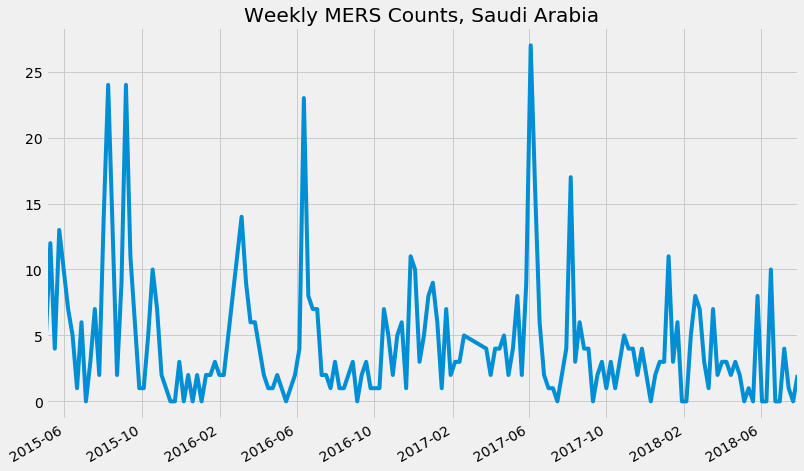

In [6]:
freq = "Weekly"
filename_ = "Saudi_Arabia_Weekly_MERS_Counts.json"
filepath_ = os.path.join(DISEASE_GSR_PATH, filename_)
with open(filepath_, "r", encoding="utf8") as f:
    gsr_ = json.load(f)
#count_dict = {parse(e["Event_Date"]).date(): e["Case_Count"] for e in gsr_}
count_values = [e["Case_Count"] for e in gsr_]
index_ = pd.DatetimeIndex([parse(e["Event_Date"]).date() for e in gsr_])
count_ser = pd.Series(count_values, index=index_)
count_ser = count_ser.sort_index()
count_ser.plot(figsize=(12,8))
print("Data from {0} to {1}".format(count_ser.index[0], count_ser.index[-1]))
plt.title("Weekly MERS Counts, Saudi Arabia");

Backtest using January - June 2018

In [7]:
mm_ser = pd.Series({dd: dd.strftime("%B_%Y") for dd in count_ser.index})
count_df = pd.DataFrame({"Actual": count_ser,
                         "Month": mm_ser})

In [8]:
# Test Cell
count_df.tail()

,Actual,Month
2018-07-01,0.0,July_2018
2018-07-08,4.0,July_2018
2018-07-15,1.0,July_2018
2018-07-22,0.0,July_2018
2018-07-29,2.0,July_2018


July_2018
2018-06-03     0.0
2018-06-10     0.0
2018-06-17    10.0
2018-06-24     0.0
2018-07-01     0.0
Name: Actual, dtype: float64
            Actual      Month
2018-07-01     0.0  July_2018
2018-07-08     4.0  July_2018
2018-07-15     1.0  July_2018
2018-07-22     0.0  July_2018
2018-07-29     2.0  July_2018
2018-07-08    0.0
2018-07-15    0.0
2018-07-22    0.0
2018-07-29    0.0
2018-08-05    0.0
Freq: W-SUN, dtype: float64
Mean QS = 0.650


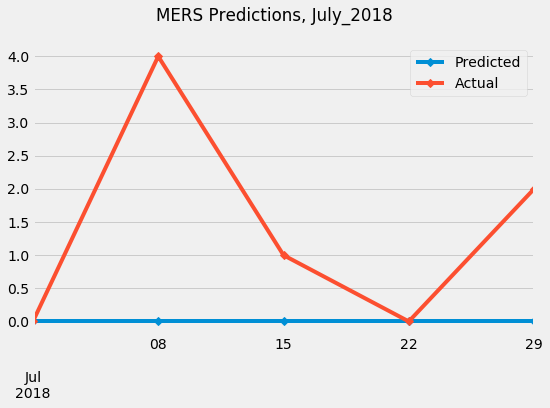

In [9]:
#for mm in test_months:
for mm in ["July_2018"]:
    print(mm)
    test_start_date = parse(" ".join(mm.split("_"))).replace(day=1)
    train = count_df[:test_start_date]["Actual"]
    print(train.tail())
    test = count_df[count_df.Month == mm]
    print(test)
    predict = hist_avg_predict(train, n_ahead=len(test))["Predictions"]
    print(predict)
    predict = [round(p) for p in predict]
    predict_ser = pd.Series(predict, index=test.index)
    predict_df = pd.DataFrame({"Predicted": predict_ser,
                               "Actual": test.Actual})
    predict_df["Quality_Score"] = predict_df.apply(lambda x: CaseCountScorer.quality_score(x.Predicted, 
                                                                                           x.Actual),
                                                   axis=1)
    qs_mean = predict_df.Quality_Score.mean()
    print("Mean QS = {:.3f}".format(qs_mean))
    predict_df["Event_Date"] = predict_df.index
    predict_df["Event_Type"] = "Disease"
    #print(predict_df)

    fig, ax = plt.subplots(1,1, figsize = (8,5))
    predict_df[["Predicted", "Actual"]].plot(marker="D", ax=ax)
    fig.suptitle("MERS Predictions, {0}".format(mm))
    #plt.title(plt_title)
    plot_filename = "MERS GSR and BR Warnings {0}.png".format(mm)
    plot_path = os.path.join(EVT_DOC_PATH, plot_filename)
    fig.savefig(plot_path)
    br_output_df = predict_df[["Event_Type", "Event_Date"]]
    br_output_df["Case_Count"] = predict_df.Predicted
    br_output_df["Country"] = "Saudi Arabia"
    br_output_df["Warning_ID"] = br_output_df.apply(lambda x: "BR_CU_MERS_{0}".format(x.Event_Date.strftime("%Y-%m-%d")),
                                                    axis=1)
    #print(br_output_df.head(2))
    out_filename = "MERS_BR_Warnings_{0}.json".format(mm)
    out_path = os.path.join(DIS_WARN_PATH, out_filename)
    out_json = br_output_df.to_json(force_ascii=False, orient="records", 
                                    date_format="iso", path_or_buf=out_path)
    with open(out_path, "r", encoding="utf8") as f:
        warn_json = json.load(f)
    #print(warn_json)
    for k in warn_json:
        k["Event_Date"] = k["Event_Date"][:10]
        #k["Model_Details"] = "Historical Average Model" 
    warn_json = {"participant_id": PARTICIPANT_ID, "payload": warn_json}
    with open(out_path, "w") as f:
        json.dump(warn_json, f, ensure_ascii=False, indent=2)